# Imports

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

from copy import deepcopy

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication
import datetime as dt

import panel as pn # for interactive widgets
# pn.extension()
pn.extension('tabulator')

In [2]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

# import neuropy.core as core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch
from neuropy.core.epoch import NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
from neuropy.analyses.placefields import PlacefieldComputationParameters

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [3]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

from PendingNotebookCode import debug_print_spike_counts, compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields

# Load Session Data

In [151]:
# KDiba Old Format:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
# 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session...
curr_active_epoch_timeslice_indicies: Int64Index([   27,    28,    29,    30,    31,    32,    33,    34,    35,
               36,
            ...
            52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147,
            52148],
           dtype='int64', length=52122)
 	 np.shape(curr_active_epoch_timeslice_indicies): (52122,)
curr_active_epoch_timeslice_indicies: Int64Index([52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157,


### Debugging

In [ ]:
# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\n session.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

In [ ]:
# debug_print_spike_counts(sess)

# sess.spikes_df unique aclu values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
#  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
#  50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
# sess.spikes_df unique aclu value counts: [    0     0  1707  1359   554  3066 91337  2707   294  2991   913  1278
#   1221  5475  2880 36760 48449   523  2595  3025 34729  3958  5263   790
#    663  1070  1078  2954  4044  2581 73951  4871 13444   476  1234 89854
#   5822 14961  2682  1184 13575 83972   795 22769  1559  8307  2098   438
#   3476 28370 43854  1355  2552  2875 59011  1440 75786  3656   875 17727
#  77247   550   408  2627  1734  2799]

# sess.spikes_df unique unit_id values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
#  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
# sess.spikes_df unique unit_id value counts: [ 1707  1359   554  3066 91337  2707   294  2991   913  1278  1221  5475
#   2880 36760 48449   523  2595  3025 34729  3958  5263   790   663  1070
#   1078  2954  4044  2581 73951  4871 13444   476  1234 89854  5822 14961
#   2682  1184 13575 83972   795 22769  1559  8307  2098   438  3476 28370
#  43854  1355  2552  2875 59011  1440 75786  3656   875 17727 77247   550
#    408  2627  1734  2799]

# sess.neurons.spiketrains
# sess.neurons.n_spikes

## Note the unit_id seems to have valid spikes for all of them, while the aclu does not!
sess.spikes_df # 1014937

sess.laps
# np.where(np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.maze_id == 2)))
# sess.spikes_df.lap.values[np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.lap_maze == 2))]


# test_df = sess.spikes_df
# test_df


# laps_epoch = Epoch(sess.laps.to_dataframe())
# laps_epoch.to_dataframe()


In [ ]:
lap_specific_subsessions = list()
lap_grouped_spikes_df = sess.spikes_df.groupby(['lap']) #  as_index=False keeps the original index

In [ ]:
i = 2
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))
# lap_specific_subsessions.append(sess.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))

In [ ]:
i = 3
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))

In [ ]:
lap_specific_session = DataSession.concat(lap_specific_subsessions)
lap_specific_session

In [ ]:
lap_specific_session.neurons.n_spikes # this looks right.

lap_specific_session.position.print_debug_str() # this looks right.

# len(sess.neurons.n_spikes) # 64 items long
# sess.neurons.n_spikes
# array([ 1707,  1359,   554,  3066, 91337,  2707,   294,  2991,   913,
#         1278,  1221,  5475,  2880, 36760, 48449,   523,  2595,  3025,
#        34729,  3958,  5263,   790,   663,  1070,  1078,  2954,  4044,
#         2581, 73951,  4871, 13444,   476,  1234, 89854,  5822, 14961,
#         2682,  1184, 13575, 83972,   795, 22769,  1559,  8307,  2098,
#          438,  3476, 28370, 43854,  1355,  2552,  2875, 59011,  1440,
#        75786,  3656,   875, 17727, 77247,   550,   408,  2627,  1734,
#         2799])



## Laps: Create version of Session that only includes activity during the laps

In [102]:
lap_specific_epochs = sess.laps.as_epoch_obj()
# lap_specific_epochs.to_dataframe()
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(sess.laps.lap_id), 2)])
# odd_lap_specific_epochs

# even_lap_specific_session = [lap_specific_sessions[i] for i in np.arange(0, len(sess.laps.lap_id), 2)]
# odd_lap_specific_session = [lap_specific_sessions[i] for i in np.arange(1, len(lap_specific_sessions), 2)]
# even_lap_specific_session
# range(0, 2, len(lap_specific_sessions))

### Lap Specific Session Debugging

In [ ]:
sess.laps.lap_id # 1-80

In [ ]:
sess.laps.to_dataframe()

In [ ]:
lap_specific_session.flattened_spiketrains

In [ ]:
# lap_specific_session.position
# sess.neurons.spiketrains
sess.flattened_spiketrains.spikes_df

In [ ]:
sess.flattened_spiketrains.spikes_df
neurons_obj = Neurons.from_dataframe(sess.flattened_spiketrains.spikes_df, sess.recinfo.dat_sampling_rate, time_variable_name='t_rel_seconds')
neurons_obj

In [ ]:
## Filtering Testing:
temp_spikes_df = deepcopy(sess.flattened_spiketrains.spikes_df)
curr_lap_spikes_df = temp_spikes_df.loc[temp_spikes_df['lap'] != -1]
curr_lap_spikes_neurons_obj = Neurons.from_dataframe(curr_lap_spikes_df, sess.recinfo.dat_sampling_rate, time_variable_name='t_rel_seconds')
print_subsession_neuron_differences(sess.neurons, curr_lap_spikes_neurons_obj)
# Asign the result to the lap_specific_session
lap_specific_session.flattened_spiketrains = FlattenedSpiketrains(curr_lap_spikes_df, time_variable_name='t_rel_seconds', t_start=0.0)
lap_specific_session.neurons = curr_lap_spikes_neurons_obj

# Filter Session by Epoch:

In [152]:
sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# sess.epochs.to_dataframe()
active_epoch = sess.epochs.get_named_timerange('maze1')
# print('active_epoch: {}'.format(active_epoch))
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right                                                   
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
# print(sess.neurons.n_spikes)

# # ## Lap_specific Spikes Only:
# active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
# # print(active_lap_specific_epoch_session.neurons.n_spikes)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1739.1533641185379)
69142/932598 total spikes spanning 40/64 units remain in subsession


## Compute Placefields if needed:

In [153]:
## Configure Placefield Calc:
should_display_2D_plots = True

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5) # works well
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2.5, smooth=1.5)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.5, 0.5), frate_thresh=0.0)
print(active_config.computation_config)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 10), smooth=(0.5, 0.5), frate_thresh=0.0) ## Works well for 2D Placemaps
# height: 20.0
# width: 250.0
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 0.2), smooth=(0.5, 0.5)) ## Extremely Slow
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 1.0), smooth=(0.5, 0.5)) ## Very slow, doesn't work

# active_config.computation_config.frate_thresh = 0.0
## Threshold the occupancy: any bins with less than 10ms occupancy are excluded.

# # active_epoch_session.position._data['lin_pos']
# # test_obj = active_epoch_session.position
# # time = sess.position.time
# # time = active_epoch_session.position.time
# # dt = np.diff(time)
# # print('min sampling rate: {} Hz\nmean sampling rate: {} Hz\nmax sampling rate: {} Hz'.format((1.0 / np.min(dt)), (1.0 / np.median(dt)), (1.0 / np.max(dt)) ))
# # np.var(dt)
# # # plt.hist(dt)
# # plt.plot(time, np.insert(dt, 0, np.nan))

# # sess.position._data['t'].iloc[0]
# # active_epoch_session.position._data['t'].iloc[-1]
# # active_epoch_session.position._data['t'][0]

# # active_epoch_session.position.x
# # active_epoch_session.position.has_linear_pos
# # test_pos = DataSession.compute_linear_position(sess)
# acitve_epoch_timeslice_indicies1, active_positions_maze1, linearized_positions_maze1 = DataSession.compute_linearized_position(sess, 'maze1', method='pca')
# # np.sum(np.logical_not(np.isnan(linearized_positions_maze1.x))) # 52122

# # pos_df = deepcopy(sess.position._data)
# # print(np.sum(np.logical_not(np.isnan(pos_df['lin_pos']))))
# # pos_df.loc[acitve_epoch_timeslice_indicies1, ['lin_pos']] = np.expand_dims(linearized_positions_maze1.x, axis=1)

# sess.position._data.loc[acitve_epoch_timeslice_indicies1, ['lin_pos']] = np.expand_dims(linearized_positions_maze1.x, axis=1)
# # np.sum(acitve_epoch_timeslice_indicies1) # 52122


# np.sum(np.logical_not(np.isnan(sess.position.linear_pos)))

# sess.position.has_linear_pos
# active_epoch_session.position.has_linear_pos

# # test_obj = deepcopy(active_epoch_session.position.linear_pos_obj)
# # test_obj

# # active_epoch_times = sess.epochs['maze1'] # array([11070, 13970], dtype=int64)
# # acitve_epoch_timeslice_indicies = sess.position.time_slice_indicies(active_epoch_times[0], active_epoch_times[1])
# # active_epoch_pos = sess.position.time_slice(active_epoch_times[0], active_epoch_times[1])
        

# # active_epoch_pos # 35643 rows x 4 columns
# # sess.position.linear_pos[acitve_epoch_timeslice_indicies]

# # for anEpochLabelName in sess.epochs.labels:
# #     curr_active_epoch_timeslice_indicies, active_positions_maze1, linearized_positions_maze1 = DataSession.compute_linearized_position(sess, epochLabelName=anEpochLabelName, method='pca')
# #     sess.position.linear_pos[curr_active_epoch_timeslice_indicies] = linearized_positions_maze1.traces.squeeze()

# # np.shape(linearized_positions_maze1.traces) # linearized_positions_maze1
# # sess = DataSessionLoader._default_compute_linear_position_if_needed(sess)

# # np.shape(sess.position.traces) # (2, 59308)

# # sess.position.to_dataframe().head(20).T

# # Save to file:
# np.savez_compressed('PositionTestingVariables', t=active_epoch_session.position.time, x=active_epoch_session.position.x, y=active_epoch_session.position.y, lin_pos=active_epoch_session.position.linear_pos, speed=active_epoch_session.position.speed)
# loaded = np.load('{}.npz'.format('PositionTestingVariables'))
# t = loaded['t']
# x = loaded['x']
# y = loaded['y']
# lin_pos = loaded['lin_pos']
# speed = loaded['speed']


<PlacefieldComputationParameters: {'speed_thresh': 1, 'grid_bin': (10, 3), 'smooth': (0.5, 0.5), 'frate_thresh': 0.0};>


In [116]:
# np.shape(linearized_positions_maze1.x) # (52122,)

# print('np.shape(acitve_epoch_timeslice_indicies1): {}'.format(np.shape(acitve_epoch_timeslice_indicies1))) # (59308,)
# print('np.shape(linearized_positions_maze1.x): {}'.format(np.shape(linearized_positions_maze1.x))) # (59308,)

# np.shape(np.expand_dims(linearized_positions_maze1.time, axis=1)) # (52122, 1)

# np.shape(acitve_epoch_timeslice_indicies1)

# linearized_positions_maze1.to_dataframe()
# np.shape(linearized_positions_maze1._data['x'].to_numpy()) # (52122,)

# sess.position.to_dataframe()
# active_epoch_session.position._data['speed'] = active_epoch_session.position.speed
active_epoch_session.position.to_dataframe().describe()

print('active_epoch_session.position.sampling_rate: {}'.format(active_epoch_session.position.sampling_rate)) # 0.033366964686904796
print('active_epoch_session.position.sampling_rate: {}'.format(1.0 / active_epoch_session.position.sampling_rate))
# # , axis=1

active_epoch_session.position.sampling_rate: 0.033366964686904796
active_epoch_session.position.sampling_rate: 29.96976228983933


In [157]:
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
# active_config.computation_config.smooth = (1.5, 0.5)
active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_session, active_config.computation_config, active_config, active_epoch_placefields1D, active_epoch_placefields2D, included_epochs=None, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the updated session using the units that have good placefields
active_epoch_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_epoch_session, active_config, active_epoch_placefields)
debug_print_spike_counts(active_epoch_session)

Recomputing active_epoch_placefields...
traces accessed with self.ndim of 1
	 done.
Recomputing active_epoch_placefields2D...
traces accessed with self.ndim of 2
_filter_by_frate(...):
	 frate_thresh: 0.0
	 n_neurons: 40
	 thresh_neurons_indx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
	 done.
skipping 2D placefield plots
good_placefield_neuronIDs: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]; (40 good)
active_epoch_session.spikes_df unique aclu values: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
active_epoch_session.spikes_df unique aclu value counts: [1588 1273  496 2632 2107  270 2680  814 1126  905 2623  488 2313 3108
 4527  651  621  888  957 2706 3143 2190  442 1086 2266 1082  687 1341
 7078 1876  400 2987 2345 1354 315

## Compute the placefields for lap-only filtered Session:

In [ ]:
try: active_lap_only_placefields1D
except NameError: active_lap_only_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_lap_only_placefields2D
except NameError: active_lap_only_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
lap_specific_config = active_config
# lap_specific_included_epochs = Epoch(sess.laps.to_dataframe())
# lap_specific_included_epochs = even_lap_specific_epochs # Kamran Right
lap_specific_included_epochs = odd_lap_specific_epochs
# active_lap_only_placefields1D, active_lap_only_placefields2D = compute_placefields_as_needed(active_lap_specific_epoch_session, lap_specific_config.computation_config, lap_specific_config, active_lap_only_placefields1D, active_lap_only_placefields2D, should_force_recompute_placefields=True, should_display_2D_plots=True)
active_lap_only_placefields1D, active_lap_only_placefields2D = compute_placefields_as_needed(active_epoch_session, lap_specific_config.computation_config, lap_specific_config, active_lap_only_placefields1D, active_lap_only_placefields2D, included_epochs=lap_specific_included_epochs, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)

# Focus on the 2D placefields:
active_lap_only_placefields = active_lap_only_placefields2D
# Get the updated session using the units that have good placefields
lap_specific_session, lap_specific_config, lap_specific_good_placefield_neuronIDs = process_by_good_placefields(active_lap_specific_epoch_session, lap_specific_config, active_lap_only_placefields)

# Pho Custom Placefield2D Implementation:


{'mode': 'bin_size', 'xstep': 10, 'ystep': 3, 'xnum_bins': 25, 'ynum_bins': 11}
{'mode': 'num_bins', 'xstep': 26.437893032395266, 'ystep': 3.2726451540029178, 'xnum_bins': 10, 'ynum_bins': 10}
xbin: [ 23.92332935  50.36122239  76.79911542 103.23700845 129.67490148
 156.11279452 182.55068755 208.98858058 235.42647361 261.86436665]
ybin: [123.85967782 127.13232297 130.40496813 133.67761328 136.95025844
 140.22290359 143.49554874 146.7681939  150.04083905 153.31348421]


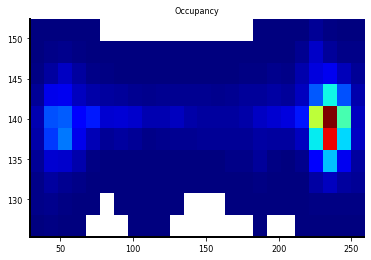

array([0.00428202, 0.00910959, 0.00666791, 0.00864966, 0.0060149 ,
       0.00297743, 0.00935232, 0.00255657, 0.00564549, 0.0087957 ,
       0.01281182, 0.0047935 , 0.01484152, 0.006012  , 0.0060492 ,
       0.00340622, 0.00612228, 0.00870146, 0.00435215, 0.00728346,
       0.01303604, 0.00413994, 0.01041662, 0.00143041, 0.00375686,
       0.00514703, 0.00185929, 0.0049702 , 0.00698511, 0.00385637,
       0.00160912, 0.00449847, 0.0027622 , 0.01194788, 0.01105833,
       0.00115784, 0.00262715, 0.0025666 , 0.00409365, 0.0169552 ])

In [148]:
from neuropy.analyses.placefields import _bin_pos, plot_occupancy, _filter_by_frate

from neuropy.core.ratemap import Ratemap

# First, interested in answering the question "where did the animal spend its time on the track" to assess the relative frequency of events that occur in a given region. If the animal spends a lot of time in a certain region,
# it's more likely that any cell, not just the ones that hold it as a valid place field, will fire there.
    # this can be done by either binning (lumping close position points together based on a standardized grid), neighborhooding, or continuous smearing. 
def _compute_occupancy(x, y, xbin, ybin, position_srate, smooth):
    # --- occupancy map calculation -----------
    # NRK todo: might need to normalize occupancy so sum adds up to 1
    # Please note that the histogram does not follow the Cartesian convention where x values are on the abscissa and y values on the ordinate axis. Rather, x is histogrammed along the first dimension of the array (vertical), and y along the second dimension of the array (horizontal).
    occupancy, xedges, yedges = np.histogram2d(x, y, bins=(xbin, ybin))
    # occupancy = occupancy.T # transpose the occupancy before applying other operations
    occupancy = occupancy / position_srate + 10e-16  # converting to seconds
    occupancy = gaussian_filter(occupancy, sigma=(smooth[1], smooth[0])) # 2d gaussian filter
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose occupancy for visualization purposes.
    return occupancy, xedges, yedges

def _compute_tuning_map(spk_x, spk_y, xbin, ybin, occupancy, smooth):
    tuning_map = np.histogram2d(spk_x, spk_y, bins=(xbin, ybin))[0]
    tuning_map = gaussian_filter(tuning_map, sigma=(smooth[1], smooth[0])) # need to flip smooth because the x and y are transposed
    tuning_map = tuning_map / occupancy
    return tuning_map


def binpos(t, x, y, gridsize):
    # original: xyt
    """ %Change the time increment of xyt to gridsize interpolate x and y.
    """
    tbin = np.linspace(t[0], t[-1], num=gridsize)
    # print(np.shape(tbin))
    # print(np.shape(t))
    xbin = np.interp(x, t, tbin)
    ybin = np.interp(y, t, tbin)
    return tbin, xbin, ybin



num_bins = (10, 10)
# tbin, xbin, ybin = binpos(pos_df.t.to_numpy(), pos_df.x.to_numpy(), pos_df.y.to_numpy(), active_config.computation_config.grid_bin_1D)
# tbin, xbin, ybin = binpos(pos_df.t.to_numpy(), pos_df.x.to_numpy(), pos_df.y.to_numpy(), 200)


pos_df = active_epoch_session.position.to_dataframe().copy()
laps_df = active_epoch_session.laps.to_dataframe().copy()
spk_df = active_epoch_session.spikes_df.copy()


# # xbin = np.arange(min(pos_df.x.to_numpy()), max(pos_df.x.to_numpy()), 1/200)  # binning of x position
# # xbin = np.linspace(min(pos_df.x.to_numpy()), max(pos_df.x.to_numpy()), num=num_bins[0]) # binning of x position
# # print('xbin: {}'.format(xbin))


## Binning with Fixed Number of Bins:    
xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), bin_size=active_config.computation_config.grid_bin) # bin_size mode
print(bin_info)
## Binning with Fixed Bin Sizes:
xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), num_bins=num_bins) # num_bins mode
print(bin_info)



print('xbin: {}'.format(xbin))
print('ybin: {}'.format(ybin))


# # Laps plotting:
# # pos_df.lin_pos.plot();
# curr_lap_id = 3
# plt.plot(pos_df.t, pos_df.lin_pos, '*');
# plt.xlim([laps_df.start[curr_lap_id], laps_df.stop[curr_lap_id]])
# # pos_df.describe()
# # pos_df.boxplot()

occupancy, xedges, yedges = _compute_occupancy(pos_df.x.to_numpy(), pos_df.y.to_numpy(), xbin, ybin, active_epoch_session.position.sampling_rate, active_config.computation_config.smooth)
# print(np.shape(occupancy))
# print(occupancy)
# plot_occupancy(occupancy)
plot_occupancy(active_epoch_placefields2D)
# tuning_map = _compute_tuning_map(
# pos_df.groupby('lap').plas.hist(alpha=0.4)
    
# Given a cell's last several seconds of its instantaneous firing rate at a given point in time, what's like likelihood that it's at a given position.
    # continuous position used.

# active_epoch_placefields1D.
# occupancy
spk_df_filtered_speed_thresh = spk_df[spk_df['speed'] >= active_config.computation_config.speed_thresh].copy() # filter out the spikes below the speed_threshold

spk_x = spk_df_filtered_speed_thresh['x'].to_numpy()
spk_y = spk_df_filtered_speed_thresh['y'].to_numpy()

tuning_map = _compute_tuning_map(spk_x, spk_y, xbin, ybin, occupancy, active_config.computation_config.smooth)
neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
# neuron_split_spike_dfs
tuning_maps = np.asarray([_compute_tuning_map(neuron_split_spike_dfs[i].x.to_numpy(), neuron_split_spike_dfs[i].y.to_numpy(), xbin, ybin, occupancy, active_config.computation_config.smooth) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
ratemap = Ratemap(
    tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=active_epoch_session.neuron_ids
)


firing_rate_max = np.asarray([np.nanmax(tuning_maps[i]) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
firing_rate_max


# plt.fastcolor(active_epoch_placefields1D.occupancy)
# Convolve the location data

In [150]:
# plot_occupancy(active_epoch_placefields2D)
filtered_tuning_maps, filter_function = _filter_by_frate(tuning_maps.copy(), 1.0)
filtered_ratemap = Ratemap(filtered_tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=filter_function(ratemap.neuron_ids))
# filtered_tuning_maps
filtered_ratemap

_filter_by_frate(...):
	 frate_thresh: 1.0
	 n_neurons: 40
	 thresh_neurons_indx: []


<Ratemap: {'_filename': None, '_metadata': None, 'tuning_curves': array([], dtype=float64), 'neuron_ids': [], 'xbin': array([ 23.92332935,  50.36122239,  76.79911542, 103.23700845,
       129.67490148, 156.11279452, 182.55068755, 208.98858058,
       235.42647361, 261.86436665]), 'ybin': array([123.85967782, 127.13232297, 130.40496813, 133.67761328,
       136.95025844, 140.22290359, 143.49554874, 146.7681939 ,
       150.04083905, 153.31348421]), 'occupancy': None};>

[ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
[ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32
 36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62]


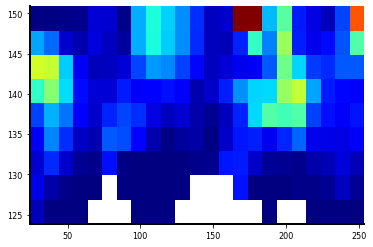

In [119]:
print(np.unique(spk_df['aclu']))
print(np.unique(spk_df['unit_id']))

curr_unit_idx = 3
mesh_X, mesh_Y = np.meshgrid(ratemap.xbin, ratemap.ybin)
pfmap = ratemap.tuning_curves[curr_unit_idx]
curr_pfmap = np.array(pfmap)
curr_pfmap = np.rot90(np.fliplr(curr_pfmap)) / np.nanmax(curr_pfmap)
plt.pcolormesh(mesh_X, mesh_Y, curr_pfmap, cmap='jet', vmin=0);


## Main Spike/Placemap plotting:

# 2D Lap Plotting

### 2D Lap Trajectories Visualization:

## 2D Placefield Plotting:

In [ ]:
# np.shape(active_epoch_placefields2D.spk_pos) # (40, 2)
# active_epoch_placefields2D.plotRaw()

# np.shape(active_epoch_placefields2D.spk_pos[0]) # (2, 1365)
# np.shape(active_epoch_placefields2D.spk_pos[1]) # (2, 1113)

# active_epoch_placefields2D.x

def filename_for_placefield(active_epoch_placefields1D, curr_cell_id):
    return active_epoch_placefields1D.str_for_filename(is_2D=False) + '-cell_{:02d}'.format(curr_cell_id)

filename_for_placefield(active_epoch_placefields1D, curr_cell_id) # filename_for_placefield(active_epoch_placefields1D, curr_cell_id)


# active_pf_2D_identifier_string = '2D Placefields - {}'.format(active_epoch_name)
# # plt.title(active_pf_2D_identifier_string)
# active_pf_2D_output_filename = '{}.pdf'.format(active_pf_2D_identifier_string)
# active_pf_2D_output_filepath = active_config.plotting_config.active_output_parent_dir.joinpath(active_pf_2D_output_filename)
# print('Saving 2D Placefield image out to "{}"...'.format(active_pf_2D_output_filepath))
# for aFig in active_pf_2D_figures:
#     aFig.savefig(active_pf_2D_output_filepath)
# print('\t done.')

        
# curr_i = 5
# # plot one of them:
# plt.figure(clear=True)
# plt.scatter(active_epoch_placefields2D.spk_pos[curr_i][0], active_epoch_placefields2D.spk_pos[curr_i][1])
# plt.show()

In [ ]:
int_input = pn.widgets.IntInput(name='IntInput', value=5, step=1, start=0, end=len(active_epoch_placefields2D.cell_ids))
curr_cell_id = int_input.value
int_input


In [ ]:
from PhoPositionalData.plotting.placefield import plot_1D_placecell_validation

def plot_1d_placecell_validations(active_placefields1D, should_save=False, modifier_string=''):
    n_cells = active_placefields1D.ratemap.n_neurons
    if should_save:
        curr_parent_out_path = active_config.plotting_config.active_output_parent_dir.joinpath('1d Placecell Validation')
        curr_parent_out_path.mkdir(parents=True, exist_ok=True)
        
    for i in np.arange(n_cells):
        curr_cell_id = active_placefields1D.cell_ids[i]
        fig, axs = plot_1D_placecell_validation(active_placefields1D, i)
        if should_save:
            curr_cell_filename = 'pf1D-' + modifier_string + filename_for_placefield(active_placefields1D, curr_cell_id) + '.png' # filename_for_placefield(active_epoch_placefields1D, curr_cell_id)
            # active_pf_2D_output_filename = '{}.pdf'.format(active_pf_2D_identifier_string)
            active_pf_curr_cell_output_filepath = curr_parent_out_path.joinpath(curr_cell_filename)
            fig.savefig(active_pf_curr_cell_output_filepath)

plot_1d_placecell_validations(active_epoch_placefields1D, should_save=True)
# plot_1d_placecell_validations(active_epoch_placefields1D, modifier_string='lap_only', should_save=False)


In [ ]:
# active_epoch_session.laps.to_dataframe()
def _compute_laps_position_data(sess):
    curr_position_df = sess.compute_position_laps()
    # adds a 'lap_dir' column, containing 0 if it's an outbound trial, 1 if it's an inbound trial, and -1 if it's neither.
    # curr_position_df['lap_dir'] = np.full_like(curr_position_df['lap'], -1)
    # curr_position_df.loc[np.logical_not(np.isnan(curr_position_df.lap.to_numpy())), 'lap_dir'] = np.mod(curr_position_df.loc[np.logical_not(np.isnan(curr_position_df.lap.to_numpy())), 'lap'], 2.0)
    lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
    return curr_position_df, lap_specific_position_dfs


# def _plot_helper_add_lap_indicators_2d(sess):
    


laps_pos_df, lap_specific_position_dfs = _compute_laps_position_data(sess)
print(laps_pos_df)

# laps_pos_df = laps_pos_df[laps_pos_df.lap != np.nan]
# laps_pos_df[laps_pos_df.lap == 1.0]

# valid_laps_indicies = np.where((laps_pos_df.lap.to_numpy() == 1.0))
# valid_laps_indicies = (laps_pos_df.lap.to_numpy() != 2.0)
valid_any_laps_indicies = np.isnan(laps_pos_df.lap.to_numpy()) # all valid lap indicies
valid_even_laps_indicies = (np.logical_or(valid_any_laps_indicies, (laps_pos_df.lap_dir.to_numpy() != 0)))
valid_odd_laps_indicies = (np.logical_or(valid_any_laps_indicies, (laps_pos_df.lap_dir.to_numpy() != 1)))
t_even = np.ma.masked_where(valid_even_laps_indicies, laps_pos_df.t.to_numpy())
x_even = np.ma.masked_where(valid_even_laps_indicies, laps_pos_df.x.to_numpy())
y_even = np.ma.masked_where(valid_even_laps_indicies, laps_pos_df.y.to_numpy())

t_odd = np.ma.masked_where(valid_odd_laps_indicies, laps_pos_df.t.to_numpy())
x_odd = np.ma.masked_where(valid_odd_laps_indicies, laps_pos_df.x.to_numpy())
y_odd = np.ma.masked_where(valid_odd_laps_indicies, laps_pos_df.y.to_numpy())

# plt.plot(t1, x1)

In [ ]:
### TODO: attempt to filter the active_epoch_session's lap ID's by the dataframe
# curr_position_df = active_epoch_session.compute_position_laps()
# lap_id_is_included = (curr_position_df.groupby('lap')['lap'].agg(['value_counts']).to_numpy() > 0)
# lap_id_is_included

In [ ]:
# active_epoch_placefields2D.plotRaw()
curr_cell_id = 1
fig, ax = active_epoch_placefields2D.plotRaw_v_time(curr_cell_id)
ax[0].plot(t_even, x_even, 'g', alpha=0.5)
ax[0].plot(t_odd, x_odd, 'r', alpha=0.5)
# active_epoch_placefields2D.t
# active_epoch_placefields2D.x
# plt.gca()
# np.isin(active_epoch_placefields2D.t, 
# y3 = np.ma.masked_where(y > 0.7, y)

In [ ]:
active_epoch_placefields2D.plotMap(figsize=(12,20), enable_spike_overlay=True)

# 3D Plots

### 3D Lap Trajectories Visualization:

In [ ]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
p, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=10, active_page_index=1)
p.show()

## Tuning Curves 3D Plot:

In [ ]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

### Tuning-Curve Height Spikes Plot Testing:

In [ ]:
## Getting the proper z-position for the tuning curve:
# Create source to ray trace
sphere = pv.Sphere(radius=0.85)

# Define a list of origin points and a list of direction vectors for each ray
# vectors = [ [cos(radians(x)), sin(radians(x)), 0] for x in range(0, 360, 5)]

# origins = [[0, 0, 0]] * len(active_lap_specific_epoch_session.spikes_df['x'])
# origins = np.hstack(active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T, np.full_like(active_lap_specific_epoch_session.spikes_df['x'].to_numpy(), 0.0))
# origins[0,:]
# spike_series_identities = active_flattened_spike_identities # currently unused

vectors = [[0, 0, 10.0]] * len(active_lap_specific_epoch_session.spikes_df['x']) # just up in the z-direction
spike_series_positions = active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T    
z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
origins = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
# origins

# Perform ray trace
# Define line segment
# start = [0, 0, 0]
# stop = [0.25, 1, 0.5]

curr_idx = 0
curr_tuning_curve_mesh = ipcDataExplorer.plots['tuningCurvePlotActors'][curr_idx]
start = origins[curr_idx]
stop = start + vectors[curr_idx]

# Perform ray trace
# points, ind = sphere.ray_trace(start, stop)
points, ind = curr_tuning_curve_mesh.ray_trace(start, stop)
pActiveTuningCurvesPlotter.add_mesh(ray, color="blue", line_width=5, name='test_ray', label="Ray Segment")
pActiveTuningCurvesPlotter.add_mesh(intersection, color="maroon",
           point_size=25, label="Intersection Points", name='test_ray_intersection')
# points, ind_ray, ind_tri = sphere.multi_ray_trace(origins, vectors)

## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

## CustomDataExplorer 3D Plotter:

In [ ]:
from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
active_laps_config = InteractivePlaceCellConfig(active_session_config=sess.config, active_epochs=None, video_output_config=None, plotting_config=None) # '3|1    
active_laps_config.plotting_config = PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', sess.config.session_name, 'custom_laps'))

try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer = InteractiveCustomDataExplorer(active_laps_config, sess, extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=pActiveInteractiveLapsPlotter)

In [ ]:
# surf = points.reconstruct_surface()

def perform_plot_flat_arena(p, x, y, bShowSequenceTraversalGradient=False):
    # Call with:
    # pdata_maze, pc_maze = build_flat_map_plot_data() # Plot the flat arena
    # p.add_mesh(pc_maze, name='maze_bg', color="black", render=False)
    def __build_flat_map_plot_data(x, y):
        # Builds the flat base maze map that the other data will be plot on top of
        ## Implicitly relies on: x, y
        z = np.zeros_like(x)
        point_cloud = np.vstack((x, y, z)).T
        pdata = pv.PolyData(point_cloud)
        pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])
        geo = pv.Circle(radius=0.5)
        pc = pdata.glyph(scale=False, geom=geo)
        return pdata, pc

    pdata_maze, pc_maze = __build_flat_map_plot_data(x, y)
    surf = pdata_maze.reconstruct_surface()
    
    return p.add_mesh(pc_maze, name='maze_bg', label='maze', color="black", render=True)    
    # # bShowSequenceTraversalGradient
    # if bShowSequenceTraversalGradient:
    #     traversal_order_scalars = np.arange(len(x))
    #     return p.add_mesh(pc_maze, name='maze_bg', label='maze', scalars=traversal_order_scalars, render=True)

iplapsDataExplorer.plots['maze_bg'] = perform_plot_flat_arena(pActiveInteractiveLapsPlotter, iplapsDataExplorer.x, iplapsDataExplorer.y)



In [ ]:
len(sess.laps.lap_id) # 44

In [ ]:
for i in np.arange(len(sess.laps.lap_id)):
    curr_lap_id = sess.laps.lap_id[i]
    curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    curr_lap_position_traces = laps_position_traces[i]
    plot_lap_trajectory_path_spline(iplapsDataExplorer, curr_lap_position_traces, curr_lap_id)

In [ ]:
# p = pv.Plotter(shape=(5, 1), border=True)
p = pActiveInteractiveLapsPlotter
num_laps_to_show = len(sess.laps.lap_id)
num_laps_to_show = 5
flat_lap_id_index = np.arange(len(sess.laps.lap_id))
# subplot_lap_id_index = np.reshape([4,11])
for i in np.arange(num_laps_to_show):
    curr_lap_id = sess.laps.lap_id[i]
    p.subplot(i, 0)
    # curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    plot_lap_trajectory_path_spline(iplapsDataExplorer, laps_position_traces[i], curr_lap_id)
    
p.link_views()  # link all the views
p.show()

In [ ]:
# ipspikesDataExplorer.spikes_main_historical.SetVisibility(0)

# ipspikesDataExplorer.spikes_main_historical.SetVisibility(1)
# bool(ipspikesDataExplorer.spikes_main_historical.GetVisibility())

ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# toggle_visibility(ipspikesDataExplorer.spikes_main_historical)

In [ ]:
ipspikesDataExplorer.toggle_plot_visibility('lap_location_trail')

In [ ]:
# ipspikesDataExplorer.spikes_main_recent_only.SetVisibility(True)
toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')

## Debugging Index Issues:

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


In [ ]:
## Timestamp Fixing:
def tt(position_timestamps, t_begin, SampleRate):
    return ((position_timestamps - t_begin) / (1e6 * SampleRate))

# sess.laps.lap_start_stop_flat_idx

sess.recinfo.dat_sampling_rate


# Programmatically change the animal position trail:

In [ ]:
def get_lap_position(curr_lap_id):
    curr_position_df = sess.position.to_dataframe()
    curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
    print('lap[{}]: ({}, {}): '.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop))

    curr_lap_position_df_is_included = curr_position_df['t'].between(curr_lap_t_start, curr_lap_t_stop, inclusive=True) # returns a boolean array indicating inclusion in teh current lap
    curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
    # curr_position_df.query('-0.5 <= t < 0.5')
    curr_lap_position_traces = curr_lap_position_df[['x','y']].to_numpy().T
    print('\t {} positions.'.format(np.shape(curr_lap_position_traces)))
    # print('\t {} spikes.'.format(curr_lap_num_spikes))
    return curr_lap_position_traces

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

curr_lap_id = int_input.value

# plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
plot_lap_trajectory_path_spline(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showing/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
# From the laps and position dataframe, extract which lap every position belongs to:

# curr_lap_position_df_is_included = curr_position_df['t'].between(laps_df['start'], laps_df['stop'], inclusive=True) # returns a boolean array indicating inclusion in teh current lap
# curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
# curr_position_df['lap'] = np.NaN

curr_position_df = sess.compute_position_laps()
# curr_position_df.groupby('lap').groups[1] # returns the Int64Index
# curr_position_df.groupby('lap').get_group(2)[['t','x','y','lin_pos']]

lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id]
lap_specific_position_dfs
curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
curr_lap_position_traces
curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
curr_lap_time_range

In [ ]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=len(sess.laps.lap_id), active_page_index=0)
# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=0)
# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=1)

# Programmatically change the animals location point indicator:

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_poin

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice